# Relevance Matters: How TF-IDF Finds What Counts

When we use a search engine like google we enter a query and expect to get relevant documents (or web pages) in return. How exactly does this happen? In this blog post we'll walk through tokenizing text, similarity calculations, and the secret sauce that leads to a powerful embedding called Term-Frequency Inverted Document Frequency (TF-IDF). TF-IDF is a staple of information retrieval used in various different search engines such as [elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/index-modules-similarity.html#bm25) and [Apache Solr](https://solr.apache.org/guide/8_0/term-vectors.html). In this blog post, we'll build up to the TF-IDF algorithm to explore how exactly it works.

## What Happens During Search?

One of the core pieces of information retrieval is turning a user’s query and a corpus of documents into vectors, then using mathematical distance calculations to compare them. We use vectors because they’re easier for computers to work with, and they let us leverage matrix math for speed.

That brings up a couple of key questions:
* What kind of vector embedding works best?
* What’s the best way to measure distance between them?

## Mapping Text To Vectors

Mapping our text (either query or document) can take many forms, but we'll start with a simple idea. We look at all of the words in our documents and create what is known as a *vocabulary*. A vocabulary is simply the unique words in our corpus. This means that we're not necessairly counting how many times a word occurs, but instead if it's present. From there, we can create a dense vector and use its dense representation to encode our text. If you're unfamiliar with the difference betwen dense and sparse vectors or their representations, see my blog post: [Vector Efficiency: Why Zeros Are Costing You Memory]({% post_url 2025-02-24-sparse-vs-dense-vectors %}).

We'll simulate gathering the unique words from a collection of documents and hard code our vocabulary using the [zen of python](https://en.wikipedia.org/wiki/Zen_of_Python).

In [ ]:
from this import s
import codecs
from rich import print
from rich.pretty import pprint as pp
import matplotlib.pyplot as plt
import numpy as np
import re

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [ ]:
def pprint(obj, max_length=10):
    return pp(obj,max_length=max_length)

In [ ]:
zen_of_python = codecs.decode(s, 'rot13')
print(zen_of_python)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!

The first step to take is to [tokenize](https://en.wikipedia.org/wiki/Search_engine_indexing#Tokenization) our text. There are many ways to do this, but we'll simply convert every word to lowercase and strip out punctuation. One way to do this is to use `replace` and `lower`.

In [ ]:
def tokenize(text):
    return text.lower().replace("\n", " ").replace("-"," ").replace("*"," ").replace("."," ").replace(","," ").replace("!"," ").split()

In [ ]:
tokenized_zen_of_python = tokenize(zen_of_python)
pprint(tokenized_zen_of_python)

['the', 'zen', 'of', 'python', 'by', 'tim', 'peters', 'beautiful', 'is', 'better', ... +133]

A less readable, but more compact way to do it is to use the `re` module.

In [ ]:
def tokenize(text):
    return re.findall(r"\b\w+(?:'\w+)?\b", text.lower())

In [ ]:
tokenized_zen_of_python_re = tokenize(zen_of_python)
pprint(tokenized_zen_of_python_re)

['the', 'zen', 'of', 'python', 'by', 'tim', 'peters', 'beautiful', 'is', 'better', ... +133]

Both give the same results, so it comes down to your preference.

In [ ]:
print(tokenized_zen_of_python == tokenized_zen_of_python_re)

True

To get our vocabulary, we'll use a `set` since `set`s can only contain unique values by definition.

In [ ]:
vocabulary = set(tokenized_zen_of_python)
pprint(vocabulary)

{'unless', 'if', 'a', 'practicality', 'one', 'temptation', 'to', 'never', 'nested', 'of', ... +75}

In [ ]:
print(f"Number of words in zen of python: {len(tokenized_zen_of_python)}")
print(f"Number of words in vocabulary: {len(vocabulary)}")

Number of words in zen of python: 143

Number of words in vocabulary: 85

Now that we have our vocabulary, the next step is mapping text to a vector. But rather than storing every word, we only care about the ones that actually appear. In a sparse vector, most values are zero, so we can efficiently retrieve words using only the non-zero indices—these tell us which words are present

A quirk about python sets is that they do **not** maintain order. However, python `list`s do, so we can use the built-in `sorted` function that returns our vocabulary as a sorted list that we cast to a numpy array for later.

In [ ]:
vocabulary=np.array(sorted(vocabulary))
print(vocabulary)

['a' 'although' 'ambiguity' 'and' 'are' "aren't" 'at' 'bad' 'be' 'beats'
 'beautiful' 'better' 'break' 'by' 'cases' 'complex' 'complicated'
 'counts' 'dense' 'do' 'dutch' 'easy' 'enough' 'errors' 'explain'
 'explicit' 'explicitly' 'face' 'first' 'flat' 'good' 'great' 'guess'
 'hard' 'honking' 'idea' 'if' 'implementation' 'implicit' 'in' 'is' 'it'
 "it's" "let's" 'may' 'more' 'namespaces' 'nested' 'never' 'not' 'now'
 'obvious' 'of' 'often' 'one' 'only' 'pass' 'peters' 'practicality'
 'preferably' 'purity' 'python' 'readability' 'refuse' 'right' 'rules'
 'should' 'silenced' 'silently' 'simple' 'sparse' 'special' 'temptation'
 'than' 'that' 'the' 'there' 'those' 'tim' 'to' 'ugly' 'unless' 'way'
 "you're" 'zen']

Now that we have a fixed order, we can simply map our "query" to specific indices. This just means that for `a` we'll use index `0`, `although` as index `1`, and so on. Any time these words appear in a document or query we'll use the same mapping.

As an example, if we have the query `bad dutch` we'd use our tokenizer to split into `bad` and `dutch`, and then find the corresponding indices in our vocabulary.

In [ ]:
query = "bad dutch"
indices = np.searchsorted(vocabulary,tokenize(query))
print(indices)

[ 7 20]

Next, we build our query vector. In a dense representation, we assign 1 to the indices corresponding to words that appear in our query, while all other positions in the vector remain 0.

In [ ]:
query_vector = np.zeros(shape=len(vocabulary))
query_vector[indices] = 1
print(query_vector)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

This enables us to easily lookup our query vector in our vocabulary vector.

In [ ]:
print(vocabulary[query_vector.astype(bool)])

['bad' 'dutch']

To represent this visually, we can plot all of the words in our vocabulary with the color represening words in our query and words not in our query.

In [ ]:
def visualize_query_vector(vector, vocabulary, title="Vector Representation", n_cols=10):
    vector = np.array(vector)
    vector_size = vector.size

    n_rows = (vector_size + n_cols - 1) // n_cols

    padded_vector = np.pad(vector, (0, n_cols * n_rows - vector_size), mode='constant')
    padded_vocab = np.pad(vocabulary, (0, n_cols * n_rows - len(vocabulary)), mode='constant', constant_values='')

    padded_vector_reshaped = padded_vector.reshape(n_rows, n_cols)
    padded_vocab_reshaped = padded_vocab.reshape(n_rows, n_cols)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(padded_vector_reshaped, cmap="Set3", interpolation="nearest", aspect="auto")

    for i in range(n_rows):
        for j in range(n_cols):
            if padded_vocab_reshaped[i, j] != '':
                ax.text(j, i, padded_vocab_reshaped[i, j], ha='center', va='center', 
                        fontsize=10, color="black")

    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

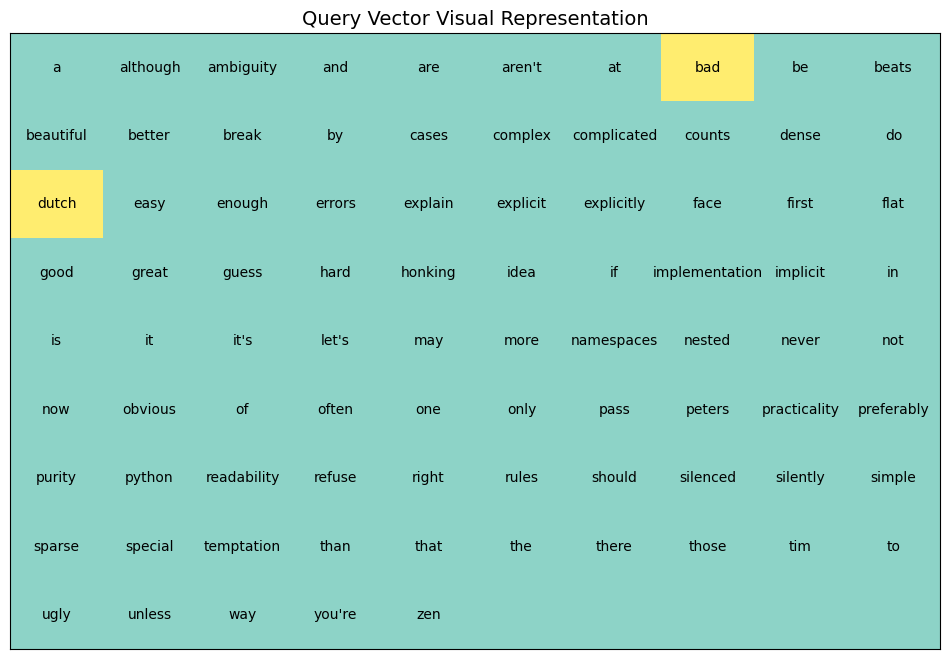

In [ ]:
visualize_query_vector(query_vector,vocabulary,title="Query Vector Visual Representation")

So we have our vocabulary, we have our query vector, now we're ready to start looking up documents in our corpus that make sense with respect to our query vector. The question now becomes: how do we find similar documents? 

## Cosine Similarity

The distance calculation for comparing vector representations of queries and documents can take many forms, but we'll start with cosine similarity. This is the same cosine function from trigonometry, but here we use it to measure the directional similarity between two vectors. For us, one vector represents our query, and the other represents a document from our corpus.

The closer two vectors are to pointing in the same direction, the more similar they are. A cosine similarity of 1 means the vectors are identical, 0 means they are completely orthogonal (unrelated), and -1 means they are pointing in exactly opposite directions. Since document vectors are typically non-negative, we usually deal with cosine similarity values between 0 and 1, where higher values indicate stronger similarity.

The cosine similarity function is the [dot product](https://en.wikipedia.org/wiki/Dot_product) of our two vectors divded by the product of the [magnitudes](https://en.wikipedia.org/wiki/Magnitude_(mathematics)#Euclidean_vector_space). Another word for magnitude in this case is "Euclidean norm" or "L2 norm." All mean the same thing in this case, which is simply the square root of the sum of squares. The dot product is the sum of the element wise products of the vectors.


\begin{align*}
    {\text{dot product}} &= \mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i \\ 
    {\text{L2 norm}} &= \|\mathbf{A}\|_2 = \sqrt{\sum_{i=1}^{n} A_i^2} \\ 
    {\text{cosine similarity}} &= \cos(\theta ) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
\end{align*}

Luckily for us, numpy makes this a relatively simple function with [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) and [`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

In [ ]:
def cosine_similarity(vector_a, vector_b):
    return np.dot(vector_a, vector_b)/(np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

Because we don't have any documents at the moment, we'll hard code a pair of document vectors to perform our cosine similarity calculations on.

In [ ]:
rng = np.random.default_rng(seed=42)

In [ ]:
def generate_different_docs_same_cosine(query_vector, num_non_zero, rng):
    query_ones = np.where(query_vector == 1)[0]
    all_indices = np.arange(query_vector.size)

    num_shared = min(num_non_zero // 2, len(query_ones))
    
    shared_indices = rng.choice(query_ones, size=num_shared, replace=False)

    num_remaining = num_non_zero - num_shared

    remaining_choices = np.setdiff1d(all_indices, shared_indices)

    doc1_extra = rng.choice(remaining_choices, size=num_remaining, replace=False)
    remaining_choices = np.setdiff1d(remaining_choices, doc1_extra)
    doc2_extra = rng.choice(remaining_choices, size=num_remaining, replace=False)

    doc1 = np.zeros_like(query_vector)
    doc2 = np.zeros_like(query_vector)

    doc1[np.concatenate([shared_indices, doc1_extra])] = 1
    doc2[np.concatenate([shared_indices, doc2_extra])] = 1

    return doc1, doc2


num_non_zero = 8

doc1_vector, doc2_vector = generate_different_docs_same_cosine(query_vector, num_non_zero, rng)

print(f"Document 1: {doc1_vector}")
print(f"Document 2: {doc2_vector}")

Document 1: [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

Document 2: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Our documents are different, but we can also verify visually to see what words were randomly selected from our vocabulary.

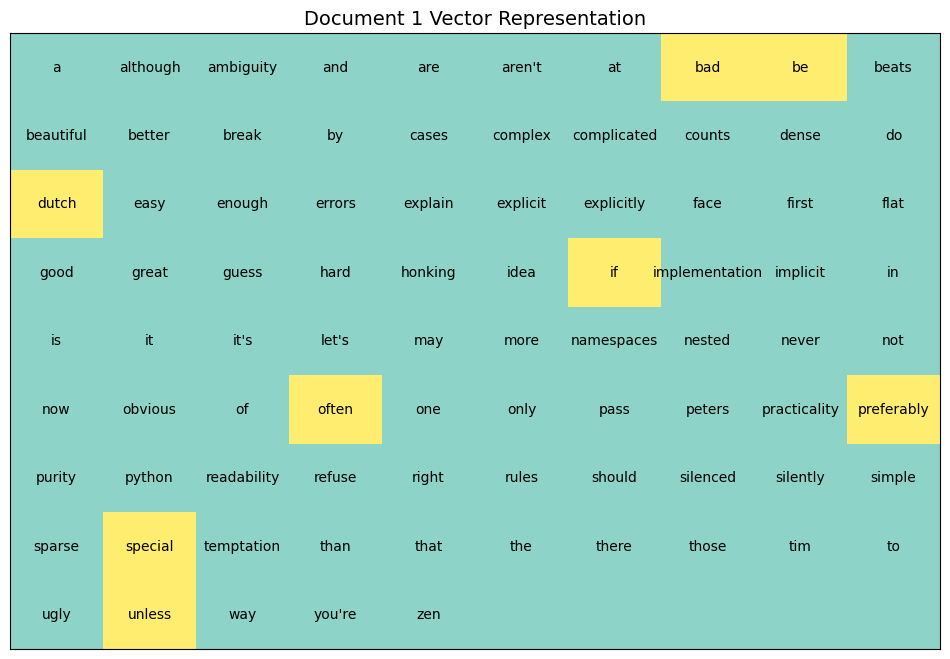

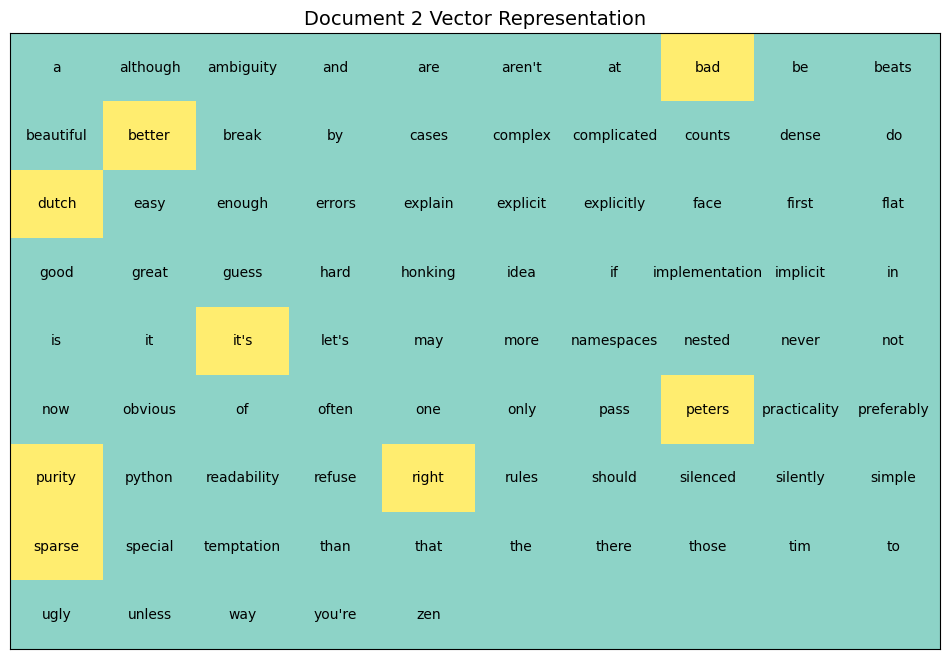

In [ ]:
visualize_query_vector(doc1_vector, vocabulary, title="Document 1 Vector Representation")
visualize_query_vector(doc2_vector, vocabulary, title="Document 2 Vector Representation")

Now that we have our documents, let's calculate the cosine similarity between each and our query vector.

In [ ]:
cos_sim_1 = cosine_similarity(query_vector, doc1_vector)
cos_sim_2 = cosine_similarity(query_vector, doc2_vector)

print(f"Cosine Similarity between query vector and document 1: {cos_sim_1}")
print(f"Cosine Similarity between query vector and document 2: {cos_sim_2}")

Cosine Similarity between query vector and document 1: 0.4999999999999999

Cosine Similarity between query vector and document 2: 0.4999999999999999

Interesting. Although we have two different documents, when we calculate the cosine similarity, the distance between the query vector and each document vector is the same. It'd be nice to visually explore why this might be happening. 

Before we can do that, it may be best to change our representation from dense to sparse. Our vector is of the same dimension as our vocabularly. Really, we want something we can visualize in 2D. Furthermore, we're storing quite a bit of information that doesn't add anything useful. Instead of using a dense representation, we can go from a `numpy` array containing mostly zeros, to a `dict` that has the key as the index in our vocabulary, and the value as the number of occurences in our query. This is called the "sparse representation." Because we only have two values in our query, we're operating in 2D. It'll also help us be able to see exactly what is going on rather than looking at the array of ones and zeros.

In [ ]:
query_vector_sparse_representation = {vocab_index:1 for vocab_index in indices}
print(query_vector_sparse_representation)

{7: 1, 20: 1}

In this case, we'll take the values from our sparse representation and use them as our query vector. To make things simple for now, we'll manually create two simulated document vectors and calculate cosine similarity. 

In [ ]:
query_vector_values_sparse = np.array(list(query_vector_sparse_representation.values())) # [bad, dutch]
doc1_vector_sparse = np.array([0,1]) # [ dutch ]
doc2_vector_sparse = np.array([1,0]) # [ bad]

In [ ]:
def plot_vectors_with_angle(v1, v2):
    v1 = np.array(v1, dtype=np.float64)
    v2 = np.array(v2, dtype=np.float64)

    cos_sim = cosine_similarity(v1, v2)
    angle_rad = np.arccos(np.clip(cos_sim, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    arc_radius = min(np.linalg.norm(v1), np.linalg.norm(v2)) * 0.3

    v1_unit = v1 / np.linalg.norm(v1)
    v2_unit = v2 / np.linalg.norm(v2)

    cross_product = np.cross(v1, v2)
    rotation_sign = np.sign(cross_product)


    theta = np.linspace(0, rotation_sign * angle_rad, 100)
    arc_x = arc_radius * np.cos(theta) * v1_unit[0] - arc_radius * np.sin(theta) * v1_unit[1]
    arc_y = arc_radius * np.cos(theta) * v1_unit[1] + arc_radius * np.sin(theta) * v1_unit[0]


    fig, ax = plt.subplots(figsize=(6, 6))

    max_val = max(np.linalg.norm(v1), np.linalg.norm(v2)) * 1.2
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)

    ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='r', label="Vector 1")
    ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='b', label="Vector 2")

    ax.plot(arc_x, arc_y, color='black', linestyle='--')


    text_radius = arc_radius * 1.5
    angle_x = text_radius * np.cos(angle_rad / 2) * v1_unit[0] - text_radius * np.sin(angle_rad / 2) * v1_unit[1]
    angle_y = text_radius * np.cos(angle_rad / 2) * v1_unit[1] + text_radius * np.sin(angle_rad / 2) * v1_unit[0]

    ax.text(angle_x, angle_y, f'{angle_deg:.2f}°', fontsize=12, color='black', 
            ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
    ax.text(0, -max_val * 0.1, f'Cosine Similarity: {cos_sim:.4f}', fontsize=12, color='darkblue', 
            ha='center', va='center', bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.3'))


    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend()
    
    plt.show()

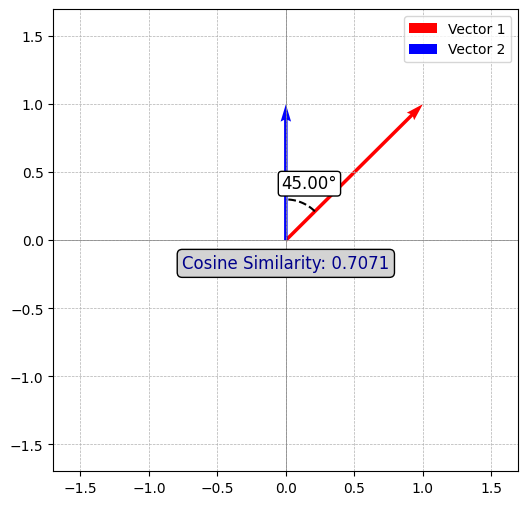

In [ ]:
plot_vectors_with_angle(query_vector_values_sparse,doc1_vector_sparse)

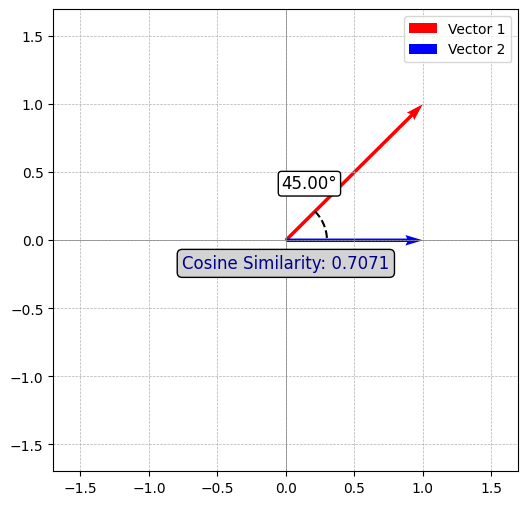

In [ ]:
plot_vectors_with_angle(query_vector_values_sparse,doc2_vector_sparse)

Now it's more clear what's happening: both of our document vectors have the same angle with respect to our query vector. Since this is the case, it's obvious that the cosine similarity would also be the same. 

In [ ]:
cos_sim_1 = cosine_similarity(query_vector_values_sparse, doc1_vector_sparse)
cos_sim_2 = cosine_similarity(query_vector_values_sparse, doc2_vector_sparse)

print(f"Cosine Similarity between query vector and document 1: {cos_sim_1}")
print(f"Cosine Similarity between query vector and document 2: {cos_sim_2}")

Cosine Similarity between query vector and document 1: 0.7071067811865475

Cosine Similarity between query vector and document 2: 0.7071067811865475

Here's an animation that shows the change in cosine similarity with respect to the angle between our two vectors.

![Cosine Similarity as Angle Changes](/assets/img/tf_idf_post/vector_animation.gif)

So far, we’ve treated this as a binary problem—either a word from our vocabulary is present in the document or it isn’t. But in practice, we need a way to measure how well a document matches our query. One approach is to count how often a word appears in the document. The idea is simple: the more frequently a query word appears, the more relevant the document is likely to be. This concept is captured by Term Frequency (TF).

Next, we’ll simulate a document where our target words appear multiple times, going beyond just an exact match.

In [ ]:
doc_words_appearing_multiple_times=np.array([2,4])
print(doc_words_appearing_multiple_times)

[2 4]

Now that we have a simulated document with increased term frequency, we'll again calculate the cosine similarity.

In [ ]:
print(f"Cosine Similarity between query and exact match: {cosine_similarity(query_vector_values_sparse, query_vector_values_sparse)}")
print(f"Cosine Similarity between query and increased term frequency: {cosine_similarity(query_vector_values_sparse, doc_words_appearing_multiple_times)}")

Cosine Similarity between query and exact match: 0.9999999999999998

Cosine Similarity between query and increased term frequency: 0.9486832980505138

We've run into an issue: our intuition says that the more often the terms in our query appear in a document, the more similar that document should be. But when we use cosine similarity, an exact match ends up being "more similar" than the same match with a higher term frequency. This happens because cosine similarity only cares about the angle between vectors, not their magnitude—so even if a document has more of the same terms, the angle doesn't shrink further once the terms are already aligned.

Visually, we can see our exact match overlaps and gives us a cosine similarity of 1.

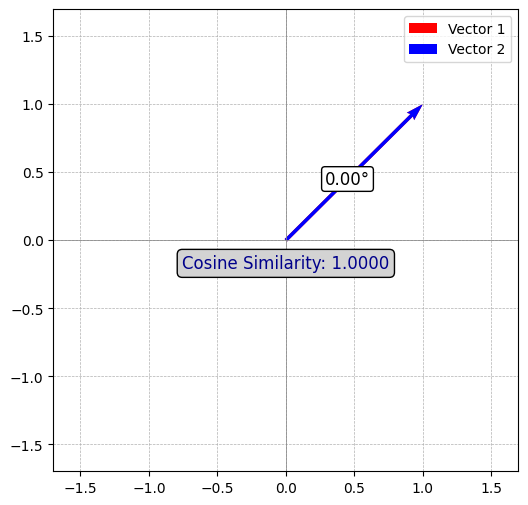

In [ ]:
plot_vectors_with_angle(query_vector_values_sparse,query_vector_values_sparse)

Our increased TF vector and our query aren't as aligned, and as a result have a lower cosine similarity.

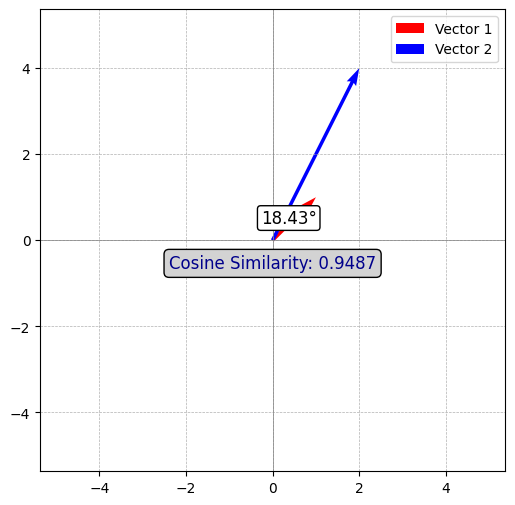

In [ ]:
plot_vectors_with_angle(query_vector_values_sparse, doc_words_appearing_multiple_times)

Let's adjust our distance calculations to better align with our intuition. Cosine similarity measures how much two vectors point in the same direction by computing the cosine of the angle between them. However, since it is normalized, it only considers direction and ignores vector magnitudes.

If we also want to factor in magnitude—giving more weight to documents with more matching terms—then we need to look at the dot product. Unlike cosine similarity, the dot product increases with both alignment and magnitude, making it a better fit when we want documents with more occurrences of our query terms to rank higher, rather than just those with the best directional match.

## The Dot Product

We can fix our issue by moving to a different distance metric: the dot product. We've already defined the dot product, but to have everything in one place, here's the equation again:


\begin{align*}
    {\text{dot product}} &= \mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i \\ 
\end{align*}


What this does for us is weights the occurence of the words by their term frequency. Dot product can take on any value greater than 0 in our case.

In [ ]:
def dot_product(vector_a, vector_b):
    return np.dot(vector_a, vector_b)

Using this as our distance metric, we again calculate between our query vector and increased term frequency document.

In [ ]:
print(f"Dot Product between query and exact match: {dot_product(query_vector_values_sparse, query_vector_values_sparse)}")
print(f"Dot Product between query and increased term frequency: {dot_product(query_vector_values_sparse, doc_words_appearing_multiple_times)}")

Dot Product between query and exact match: 2

Dot Product between query and increased term frequency: 6

Now we're aligned with our intuition: the more times the words from our query appear in the document, the more relevant our metric says that it is.

To compare our two distance calculations: 
* Cosine Similarity scores documents with similar proportions of term frequencies as more similar
* Dot Product scores documents with higher term frequencies as more similar.

However, it turns out we have an unseen problem even when we use the dot product as the distance metric: not all terms convey the same information. Not all terms are equally relevant every time they appear. 

To demonstrate, we'll use a new query and a few new documents.

In [ ]:
def term_count(content, term):
    tokenized = tokenize(content)
    term_count = tokenized.count(term.lower())
    return float(round(term_count,4))

In [ ]:
query="The Red Bull Racing Team wins the 2025 drivers championship."

In [ ]:
terms=tokenize(query)
print(terms)

['the', 'red', 'bull', 'racing', 'team', 'wins', 'the', '2025', 'drivers', 'championship']

In [ ]:
query_vector = np.ones_like(terms,dtype=int)
print(query_vector)

[1 1 1 1 1 1 1 1 1 1]

In [ ]:
docs = ["Formula 1 racing is comprised of only 20 drivers.","Red Bull didn't have the quickest car, but that didn't stop them from winning the championship.", "The worst thing about the end of the weekend is going to the grocery store for the week."]

In [ ]:
doc_vectors = [[term_count(doc,term) for term in terms] for doc in docs]
doc_dot_products = [dot_product(doc_vector,query_vector) for doc_vector in doc_vectors]

print(doc_dot_products)

[2.0, 7.0, 10.0]

Now we have a new problem. Our dot product accounted for a higher term frequency making documents more similar, but we've encountered a situation where our intuition is not backed by our relevance calculation. We'd expect the documents ordered this way by index: 1 > 0 > 2, but we actually have 2 > 1 > 0. The document in index 1 is talking about Red Bull racing winning the championship. At index 0, the document is discussing Formula 1, which is what type of racing team Red Bull is. The document at index 2 doesn't mention racing or Formula 1 at all, but ranks higher because it uses words like "the" many times. The problem we've encountered using term frequencies alone is that we're assuming that every time a term appears, it's equally relevant. This isn't always the case- especially if we have filler words like "a", "and", etc. We'd prefer if our relevance measure is higher for more terms matched in a query vs less terms with a higher number of appearances. To mitigate this, we can dampen our term frequency by taking a square root or log. For long documents, we'd generally have a much higher term frequency, so we also will normalize by the length of the document. In math that looks like this:
 
\begin{align*}
    {\text{Term Frequency}} &= {\text{TF(t,d)}} &= \sqrt{\frac{f_{t,d}}{\sum_{t\in d} f_{t,d}}}\\ 
\end{align*}


Here, $t$ is a term, and $d$ is a document. $f_{t,d}$ is the number of times a given term appears in a given document. This is relatively simple to implement in code:

In [ ]:
def tf(term, document):
    tokenized_document = tokenize(document)
    term_count = tokenized_document.count(term.lower())
    document_length = len(tokenized_document)

    return np.sqrt(term_count/document_length)

In [ ]:
doc_vectors = [[tf(term,doc) for term in terms] for doc in docs]
doc_dot_products = [dot_product(doc_vector,query_vector) for doc_vector in doc_vectors]

print(doc_dot_products)

[0.6666666666666666, 1.4571067811865475, 1.0540925533894598]

After applying this dampened term frequency calculation and taking the dot product again, we see that our most relevant document is now reflected as such, but the document talking about the grocery store still outweighs the document about Formula 1. To fix this we need a new term in our relevance calculation.

## Inverse Document Frequency

This leads us into our next component- Inverse Document Frequency (IDF). The problem we've encountered using term frequencies alone is that we're assuming that every time a term appears, it's equally relevant. This isn't the case. Words like "Racing" or "Championship" have more importance than filler words like "the." Document Frequency (DF) is the number of documents in the corpus that contain a specific term. This is a proxy for how important the term may be—the more documents it appears in, the more common the term, the less imporant it likely is. We can write this down mathematically as follows:

\begin{align*}
    {\text{Document Frequency}} &= \text{DF}(t) &= \sum_{i=1}^{|D|} 
    \begin{cases} 
      1, & \text{if } t \in D_i \\ 
      0, & \text{otherwise}
    \end{cases}
\end{align*}

Here, $|D|$ is the number of documents in our corpus, $D_i$ is the $i^{th}$ document, and $t$ is the term.

The problem now is that we want terms that appear less frequently to score higher. To use DF to do this, we take the log of the inverse with a bit of smoothing (adding 1) for edge cases and undefined errors:
\begin{align*}
    \text{Inverse Document Frequency}&= \text{IDF}(t)&= 1 + \log\left(\frac{|D| + 1}{DF(t) + 1}\right)
\end{align*}

This is known as Inverse Document Frequency (IDF). Now, lower IDF means a term is less significant and higher IDF means a term is more significant.

We can simulate document frequency in an imaginary corpus, calculate the IDF, and combine it with our existing TF to finally achieve a relevance metric that aligns with our intuition and obeys the rules that align with our intuition.

In [ ]:
simulated_df = {"the":10_000,"red":1_000,"racing":200,"bull":175,"2025":50,"drivers":100,"championship":300,"wins":500,"team":600}
total_number_of_documents = 11_000

In [ ]:
def idf(term,document_frequency,total_number_of_documents):
    return 1+np.log((total_number_of_documents+1)/(document_frequency[term]+1))

In [ ]:
idf_vector = [idf(term,simulated_df,total_number_of_documents) for term in tokenize(query)]
print(idf_vector)

[
    1.0953010897629196,
    3.396986677424215,
    5.135257461701284,
    5.00243654868036,
    3.907146522204228,
    4.089135355654571,
    1.0953010897629196,
    6.37391582401511,
    5.690620939898176,
    4.59863119199056
]

To get a feel for how our query terms and IDF relate, we can create a mapping between the two.

In [ ]:
idf_mapping = {term:idf(term,simulated_df,total_number_of_documents) for term in tokenize(query)}
print(idf_mapping)

{
    'the': 1.0953010897629196,
    'red': 3.396986677424215,
    'bull': 5.135257461701284,
    'racing': 5.00243654868036,
    'team': 3.907146522204228,
    'wins': 4.089135355654571,
    '2025': 6.37391582401511,
    'drivers': 5.690620939898176,
    'championship': 4.59863119199056
}

As expected, the less the term appears in our simulated corpus, the higher the value of IDF is. Multiplying TF and IDF together we arrive at [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency%E2%80%93inverse_document_frequency). This is the best of both worlds since we have TF that tells us how a specific term describes a document, and IDF that tells us how imporantant a specific term is in our corpus.

\begin{align*}
    \text{Term Frequency Inverse Document Frequency} &= \text{TF-IDF}(t) = \text{TF} \cdot \text{IDF}
\end{align*}


In [ ]:
def tf_idf(term,document,simulated_df,total_number_of_documents):
    return tf(term,document)*idf(term,simulated_df,total_number_of_documents)

In [ ]:
query_vector = list(np.repeat(1,len(terms)))
doc_vectors = [[tf_idf(term,doc,simulated_df,total_number_of_documents) for term in terms] for doc in docs]
document_scores = [dot_product(query_vector,document_vector) for document_vector in doc_vectors]

We've finally reached a relevance calculation that matches our intuition- the order by index we expect is 1>0>2, and TF-IDF yields this ordering.

In [ ]:
print(list(zip(docs,document_scores)))

[
    ('Formula 1 racing is comprised of only 20 drivers.', 3.5643524961928454),
    (
        "Red Bull didn't have the quickest car, but that didn't stop them from winning the championship.",
        4.0572136607913905
    ),
    (
        'The worst thing about the end of the weekend is going to the grocery store for the week.',
        1.1545487224384539
    )
]

## Conclusion

To conclude, we've worked up to a TF-IDF implementation by following our intuition. We started by looking at tokenizing strings in order to represent them as vectors. After we had our vectors, we looked at how we could compare how similar they are. We ran into a few issues with our results and intuition that caused us to pivot from cosine similarity to dot product to incorporate Term Frequency. Once we had that, we again saw an issue with all words being treated equally regardless of the number of times that appeared in our corpus. This lead us to Document Frequency and later Inverse Document Frequency.